# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|OK|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.|OK|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|OK|


### dataset
1. cityscapes datesets

### 적용할 알고리즘
1. Pix2Pix 

## 문제 정의  

> Pix2Pix 모델 구현하기  
> 픽셀 별로 레이블 정보만 존재하는 segmentation map으로 실제 도로 이미지 만들기


## 분석환경

In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


### 프로젝트 수행

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.(어떠한 방법을 사용했는지 적어주세요.)  
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.  
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.  
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.  
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


### 데이터 불러오기
* train image : 1000
* test image : 5

In [47]:
import os

data_path = './data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [48]:
import os

data_path_val = './data/cityscapes/val/'
print("number of test examples :", len(os.listdir(data_path_val)))

number of test examples : 5


<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

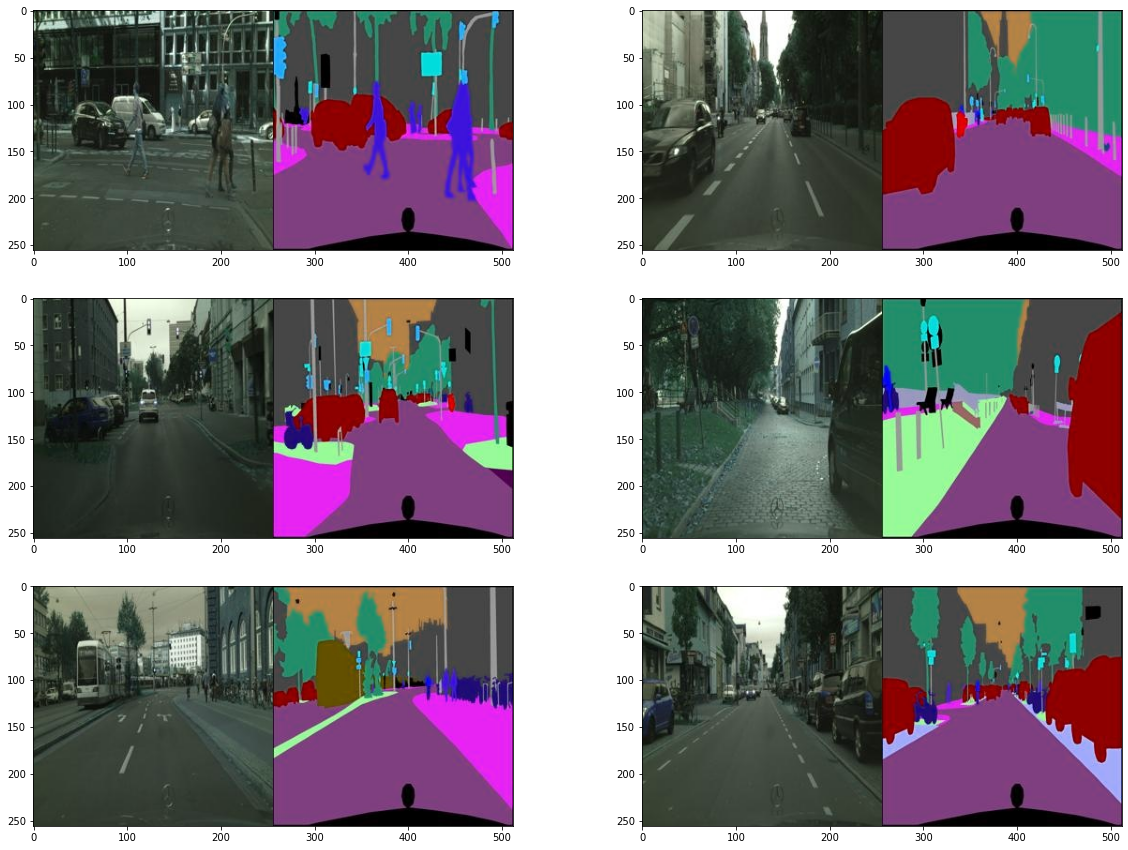

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [50]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
img.shape

(256, 512, 3)

### 2개 이미지로 분할

<Figure size 720x504 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

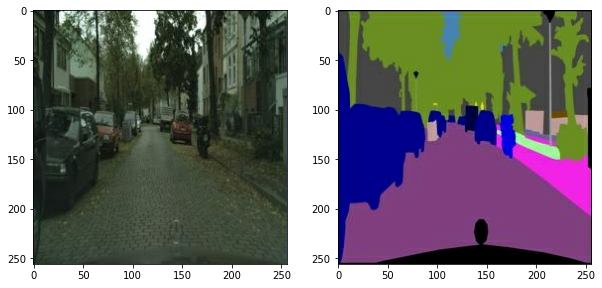

In [51]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

###  data augmentation

1. Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용(tf.pad)  
2. (256,256,6) 크기를 가진 이미지를 임의로 잘라냄(tf.image.random_crop)  
3. 가로로 뒤집기. (tf.image.random_flip_left_right)
4. 세로로 뒤집기. (tf.image.random_flip_up_down)
5. 회전시키기. (tf.image.rot90)

In [52]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

<Figure size 1080x936 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Image 1')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 1')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 2')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 2')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 3')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 3')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 4')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 4')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 5')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 5')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 6')

<AxesSubplot:>

Text(0.5, 1.0, 'Image 6')

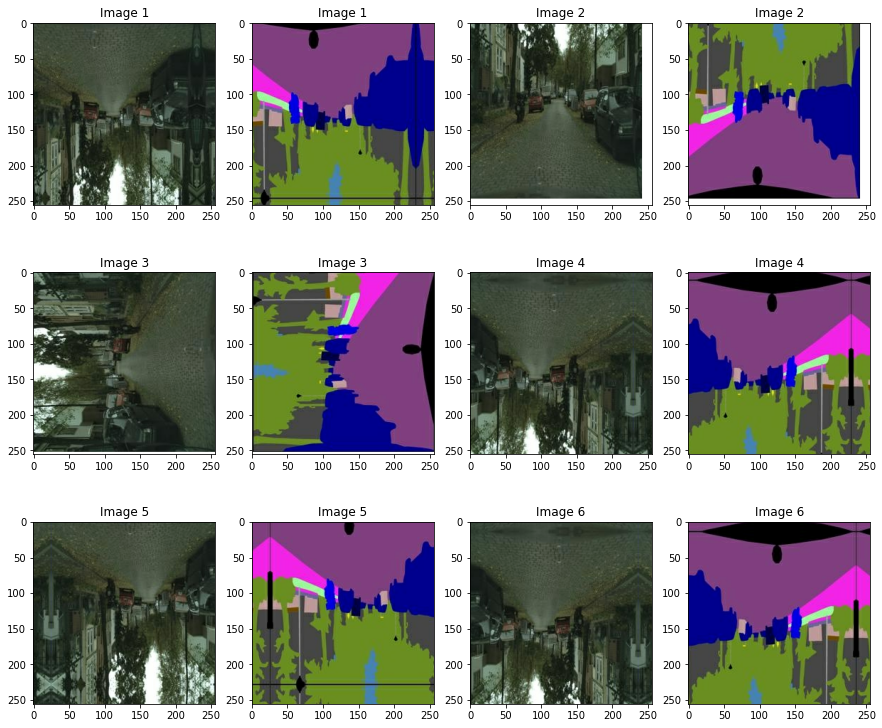

In [53]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

### augmentation 적용 확인

<Figure size 720x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

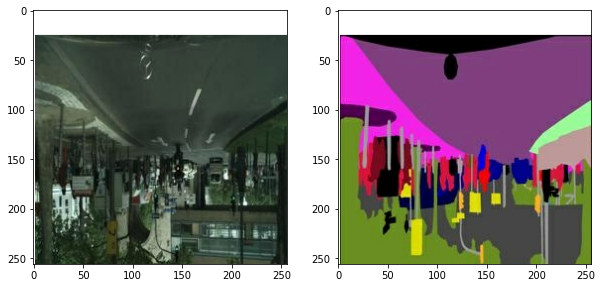

In [54]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### U-Net Generator 구현
 * 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있음
 * Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법


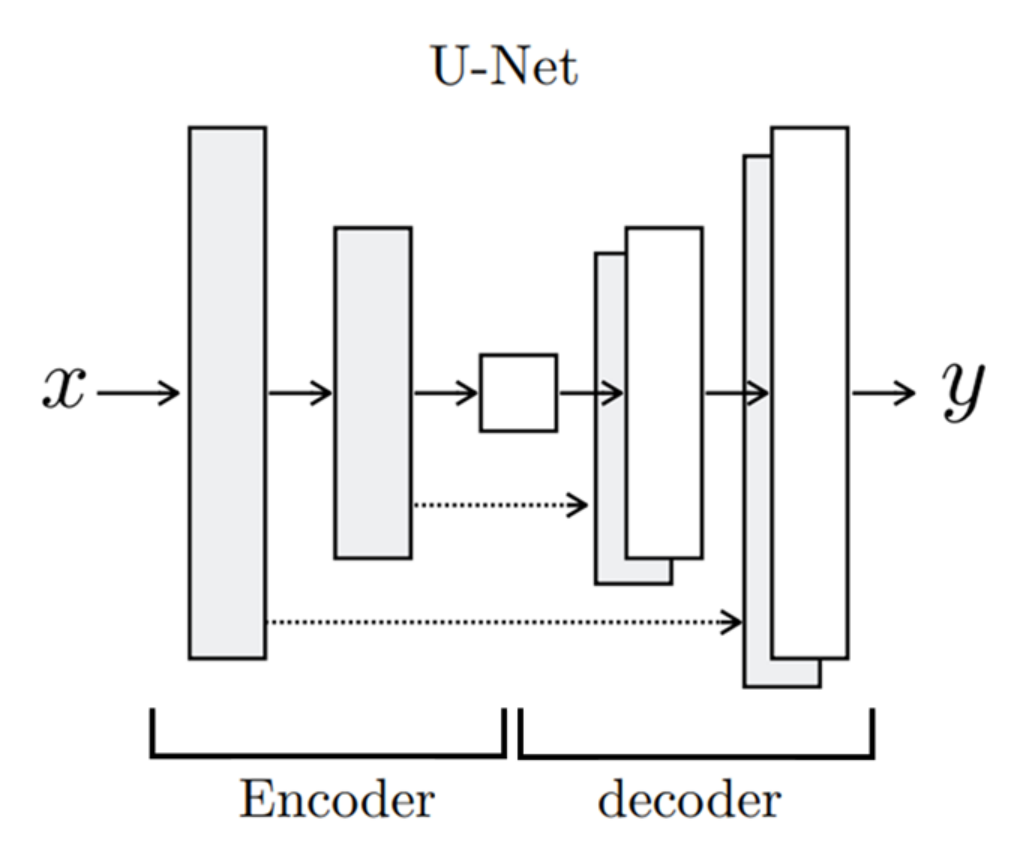

In [39]:
Image(filename='UNet_generator.png') 

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [23]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [24]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

### Discriminator 
* 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출함
* 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN이라고 불림
* 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법임

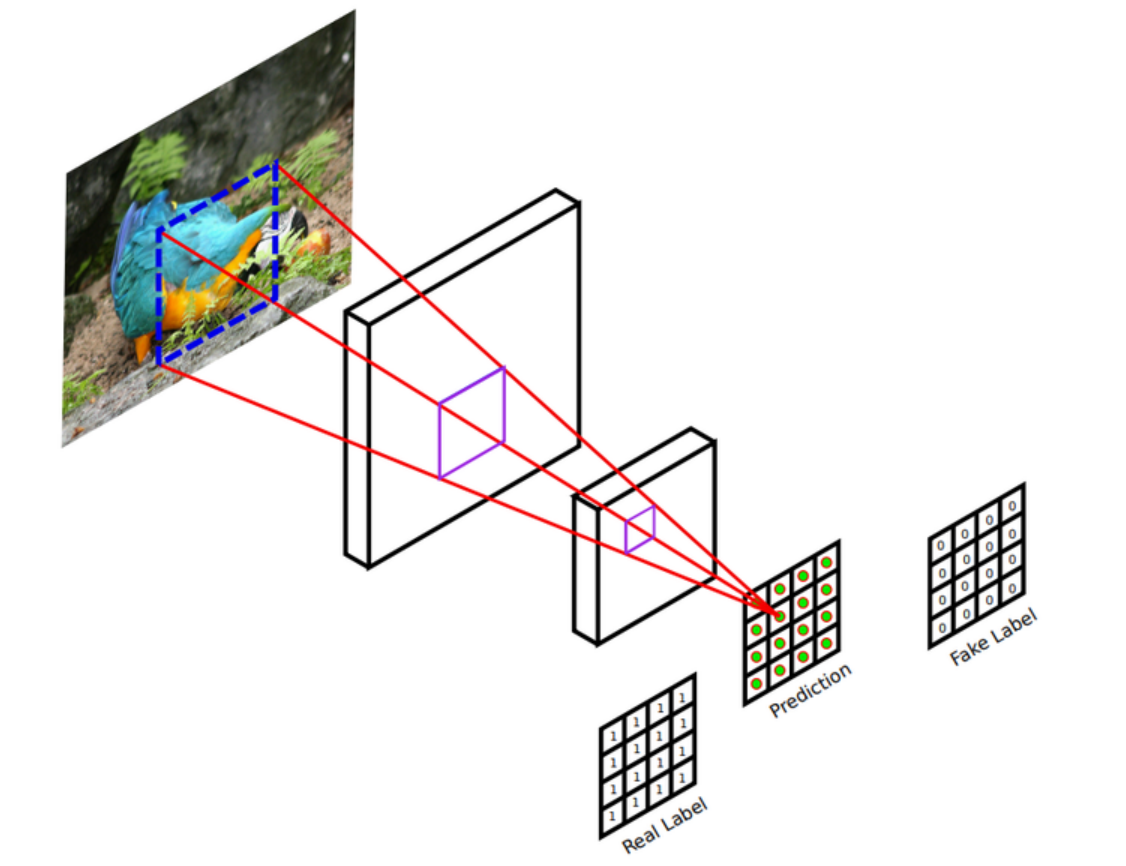

In [40]:
Image(filename='patchGan.png') 

In [25]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [26]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_32 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [27]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

In [28]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_18[0][0]       

#### discriminator 테스트 
* 입력 256 * 256 * 3 
* 출력 30 * 30 * 1

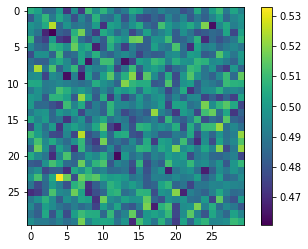

In [29]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 학습 및 테스트하기

#### loss function 
* L1 + cGAN

In [31]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


#### optimizer

In [32]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [33]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

#### 학습

In [34]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9293                     
L1_loss:0.3405                     
Discriminator_loss:1.3148

EPOCH[1] - STEP[20]                     
Generator_loss:1.1192                     
L1_loss:0.2828                     
Discriminator_loss:1.0704

EPOCH[1] - STEP[30]                     
Generator_loss:1.1490                     
L1_loss:0.3054                     
Discriminator_loss:1.1901

EPOCH[1] - STEP[40]                     
Generator_loss:1.7119                     
L1_loss:0.2665                     
Discriminator_loss:0.9923

EPOCH[1] - STEP[50]                     
Generator_loss:1.9369                     
L1_loss:0.2809                     
Discriminator_loss:1.2036

EPOCH[1] - STEP[60]                     
Generator_loss:1.6630                     
L1_loss:0.2145                     
Discriminator_loss:0.6155

EPOCH[1] - STEP[70]                     
Generator_loss:2.2112                     
L1_loss:0.2553                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.7569                     
L1_loss:0.2101                     
Discriminator_loss:0.6215

EPOCH[3] - STEP[80]                     
Generator_loss:2.2371                     
L1_loss:0.2006                     
Discriminator_loss:0.3077

EPOCH[3] - STEP[90]                     
Generator_loss:2.5755                     
L1_loss:0.1911                     
Discriminator_loss:0.6292

EPOCH[3] - STEP[100]                     
Generator_loss:1.4422                     
L1_loss:0.1934                     
Discriminator_loss:0.6563

EPOCH[3] - STEP[110]                     
Generator_loss:1.7209                     
L1_loss:0.2055                     
Discriminator_loss:0.6117

EPOCH[3] - STEP[120]                     
Generator_loss:1.6517                     
L1_loss:0.2651                     
Discriminator_loss:0.5250

EPOCH[3] - STEP[130]                     
Generator_loss:1.5088                     
L1_loss:0.2317                

EPOCH[5] - STEP[130]                     
Generator_loss:1.9460                     
L1_loss:0.1890                     
Discriminator_loss:0.6420

EPOCH[5] - STEP[140]                     
Generator_loss:2.8094                     
L1_loss:0.2677                     
Discriminator_loss:0.1979

EPOCH[5] - STEP[150]                     
Generator_loss:1.0624                     
L1_loss:0.2241                     
Discriminator_loss:0.7853

EPOCH[5] - STEP[160]                     
Generator_loss:1.1595                     
L1_loss:0.1737                     
Discriminator_loss:0.7400

EPOCH[5] - STEP[170]                     
Generator_loss:2.2087                     
L1_loss:0.1695                     
Discriminator_loss:0.5320

EPOCH[5] - STEP[180]                     
Generator_loss:1.0740                     
L1_loss:0.2190                     
Discriminator_loss:0.8007

EPOCH[5] - STEP[190]                     
Generator_loss:2.1208                     
L1_loss:0.1898             

EPOCH[7] - STEP[190]                     
Generator_loss:1.7026                     
L1_loss:0.1537                     
Discriminator_loss:0.3951

EPOCH[7] - STEP[200]                     
Generator_loss:0.6918                     
L1_loss:0.2168                     
Discriminator_loss:1.0557

EPOCH[7] - STEP[210]                     
Generator_loss:2.5966                     
L1_loss:0.1905                     
Discriminator_loss:0.6214

EPOCH[7] - STEP[220]                     
Generator_loss:1.7529                     
L1_loss:0.2392                     
Discriminator_loss:0.3484

EPOCH[7] - STEP[230]                     
Generator_loss:2.7835                     
L1_loss:0.1740                     
Discriminator_loss:0.6231

EPOCH[7] - STEP[240]                     
Generator_loss:2.1552                     
L1_loss:0.1990                     
Discriminator_loss:0.3734

EPOCH[7] - STEP[250]                     
Generator_loss:1.3438                     
L1_loss:0.1833             

EPOCH[9] - STEP[250]                     
Generator_loss:0.3892                     
L1_loss:0.1934                     
Discriminator_loss:1.3304

EPOCH[10] - STEP[10]                     
Generator_loss:1.9807                     
L1_loss:0.1646                     
Discriminator_loss:1.6462

EPOCH[10] - STEP[20]                     
Generator_loss:1.2311                     
L1_loss:0.2020                     
Discriminator_loss:1.2610

EPOCH[10] - STEP[30]                     
Generator_loss:3.1041                     
L1_loss:0.1558                     
Discriminator_loss:1.1973

EPOCH[10] - STEP[40]                     
Generator_loss:0.8081                     
L1_loss:0.1771                     
Discriminator_loss:0.7782

EPOCH[10] - STEP[50]                     
Generator_loss:0.4289                     
L1_loss:0.2097                     
Discriminator_loss:1.3797

EPOCH[10] - STEP[60]                     
Generator_loss:0.6309                     
L1_loss:0.1479             

EPOCH[12] - STEP[60]                     
Generator_loss:1.6529                     
L1_loss:0.1515                     
Discriminator_loss:0.8720

EPOCH[12] - STEP[70]                     
Generator_loss:1.5304                     
L1_loss:0.1713                     
Discriminator_loss:0.5332

EPOCH[12] - STEP[80]                     
Generator_loss:1.2539                     
L1_loss:0.1608                     
Discriminator_loss:0.5168

EPOCH[12] - STEP[90]                     
Generator_loss:2.3666                     
L1_loss:0.1481                     
Discriminator_loss:0.6714

EPOCH[12] - STEP[100]                     
Generator_loss:1.5683                     
L1_loss:0.2155                     
Discriminator_loss:0.3832

EPOCH[12] - STEP[110]                     
Generator_loss:0.8431                     
L1_loss:0.1786                     
Discriminator_loss:0.7187

EPOCH[12] - STEP[120]                     
Generator_loss:2.5902                     
L1_loss:0.1829          

EPOCH[14] - STEP[120]                     
Generator_loss:1.3983                     
L1_loss:0.1836                     
Discriminator_loss:0.6005

EPOCH[14] - STEP[130]                     
Generator_loss:3.7989                     
L1_loss:0.2062                     
Discriminator_loss:0.1608

EPOCH[14] - STEP[140]                     
Generator_loss:1.5015                     
L1_loss:0.1538                     
Discriminator_loss:0.7396

EPOCH[14] - STEP[150]                     
Generator_loss:1.3971                     
L1_loss:0.1980                     
Discriminator_loss:0.5168

EPOCH[14] - STEP[160]                     
Generator_loss:1.7905                     
L1_loss:0.1867                     
Discriminator_loss:0.7259

EPOCH[14] - STEP[170]                     
Generator_loss:3.5014                     
L1_loss:0.2039                     
Discriminator_loss:0.7664

EPOCH[14] - STEP[180]                     
Generator_loss:1.3541                     
L1_loss:0.1515      

EPOCH[16] - STEP[180]                     
Generator_loss:2.4547                     
L1_loss:0.2009                     
Discriminator_loss:0.3883

EPOCH[16] - STEP[190]                     
Generator_loss:1.5541                     
L1_loss:0.1637                     
Discriminator_loss:0.6321

EPOCH[16] - STEP[200]                     
Generator_loss:2.6047                     
L1_loss:0.1207                     
Discriminator_loss:2.2488

EPOCH[16] - STEP[210]                     
Generator_loss:1.7807                     
L1_loss:0.1561                     
Discriminator_loss:0.6845

EPOCH[16] - STEP[220]                     
Generator_loss:1.7948                     
L1_loss:0.1847                     
Discriminator_loss:0.5782

EPOCH[16] - STEP[230]                     
Generator_loss:1.2964                     
L1_loss:0.1525                     
Discriminator_loss:0.5322

EPOCH[16] - STEP[240]                     
Generator_loss:1.7319                     
L1_loss:0.1882      

EPOCH[18] - STEP[240]                     
Generator_loss:2.3048                     
L1_loss:0.1482                     
Discriminator_loss:1.0506

EPOCH[18] - STEP[250]                     
Generator_loss:1.9379                     
L1_loss:0.1708                     
Discriminator_loss:0.5859

EPOCH[19] - STEP[10]                     
Generator_loss:1.0677                     
L1_loss:0.1633                     
Discriminator_loss:0.6870

EPOCH[19] - STEP[20]                     
Generator_loss:1.7266                     
L1_loss:0.1482                     
Discriminator_loss:0.8967

EPOCH[19] - STEP[30]                     
Generator_loss:2.9441                     
L1_loss:0.1517                     
Discriminator_loss:1.1702

EPOCH[19] - STEP[40]                     
Generator_loss:2.8294                     
L1_loss:0.1526                     
Discriminator_loss:1.0306

EPOCH[19] - STEP[50]                     
Generator_loss:3.3229                     
L1_loss:0.1866           

EPOCH[21] - STEP[50]                     
Generator_loss:1.1944                     
L1_loss:0.2170                     
Discriminator_loss:0.5155

EPOCH[21] - STEP[60]                     
Generator_loss:1.8103                     
L1_loss:0.1887                     
Discriminator_loss:0.4107

EPOCH[21] - STEP[70]                     
Generator_loss:3.4578                     
L1_loss:0.1932                     
Discriminator_loss:0.0665

EPOCH[21] - STEP[80]                     
Generator_loss:0.7084                     
L1_loss:0.1815                     
Discriminator_loss:0.8215

EPOCH[21] - STEP[90]                     
Generator_loss:1.1320                     
L1_loss:0.1459                     
Discriminator_loss:0.9260

EPOCH[21] - STEP[100]                     
Generator_loss:2.1484                     
L1_loss:0.1743                     
Discriminator_loss:0.5000

EPOCH[21] - STEP[110]                     
Generator_loss:2.7452                     
L1_loss:0.1623           

EPOCH[23] - STEP[110]                     
Generator_loss:1.7154                     
L1_loss:0.1552                     
Discriminator_loss:0.5665

EPOCH[23] - STEP[120]                     
Generator_loss:2.0827                     
L1_loss:0.1632                     
Discriminator_loss:0.4051

EPOCH[23] - STEP[130]                     
Generator_loss:2.5171                     
L1_loss:0.1299                     
Discriminator_loss:0.3539

EPOCH[23] - STEP[140]                     
Generator_loss:2.2874                     
L1_loss:0.1838                     
Discriminator_loss:0.2086

EPOCH[23] - STEP[150]                     
Generator_loss:0.7172                     
L1_loss:0.1671                     
Discriminator_loss:0.8973

EPOCH[23] - STEP[160]                     
Generator_loss:1.9697                     
L1_loss:0.1439                     
Discriminator_loss:0.7041

EPOCH[23] - STEP[170]                     
Generator_loss:1.7709                     
L1_loss:0.1991      

EPOCH[25] - STEP[170]                     
Generator_loss:2.1663                     
L1_loss:0.1801                     
Discriminator_loss:0.4067

EPOCH[25] - STEP[180]                     
Generator_loss:2.6826                     
L1_loss:0.1334                     
Discriminator_loss:1.0826

EPOCH[25] - STEP[190]                     
Generator_loss:3.0354                     
L1_loss:0.1657                     
Discriminator_loss:0.3738

EPOCH[25] - STEP[200]                     
Generator_loss:2.0437                     
L1_loss:0.1725                     
Discriminator_loss:0.9329

EPOCH[25] - STEP[210]                     
Generator_loss:1.3569                     
L1_loss:0.1709                     
Discriminator_loss:0.4909

EPOCH[25] - STEP[220]                     
Generator_loss:1.4795                     
L1_loss:0.2384                     
Discriminator_loss:0.4200

EPOCH[25] - STEP[230]                     
Generator_loss:3.2121                     
L1_loss:0.1433      

EPOCH[27] - STEP[230]                     
Generator_loss:3.6914                     
L1_loss:0.1597                     
Discriminator_loss:0.1112

EPOCH[27] - STEP[240]                     
Generator_loss:2.5864                     
L1_loss:0.1396                     
Discriminator_loss:0.4611

EPOCH[27] - STEP[250]                     
Generator_loss:2.0627                     
L1_loss:0.1675                     
Discriminator_loss:0.4210

EPOCH[28] - STEP[10]                     
Generator_loss:1.7933                     
L1_loss:0.1643                     
Discriminator_loss:0.4547

EPOCH[28] - STEP[20]                     
Generator_loss:2.3707                     
L1_loss:0.1737                     
Discriminator_loss:1.2394

EPOCH[28] - STEP[30]                     
Generator_loss:2.1800                     
L1_loss:0.1777                     
Discriminator_loss:0.2062

EPOCH[28] - STEP[40]                     
Generator_loss:2.9292                     
L1_loss:0.1425          

EPOCH[30] - STEP[40]                     
Generator_loss:2.1744                     
L1_loss:0.2009                     
Discriminator_loss:0.6415

EPOCH[30] - STEP[50]                     
Generator_loss:2.2862                     
L1_loss:0.1409                     
Discriminator_loss:0.2263

EPOCH[30] - STEP[60]                     
Generator_loss:1.6618                     
L1_loss:0.1487                     
Discriminator_loss:1.2868

EPOCH[30] - STEP[70]                     
Generator_loss:1.9521                     
L1_loss:0.1126                     
Discriminator_loss:0.4072

EPOCH[30] - STEP[80]                     
Generator_loss:2.3888                     
L1_loss:0.1314                     
Discriminator_loss:1.5055

EPOCH[30] - STEP[90]                     
Generator_loss:1.9685                     
L1_loss:0.1554                     
Discriminator_loss:0.2570

EPOCH[30] - STEP[100]                     
Generator_loss:1.9598                     
L1_loss:0.1513            

EPOCH[32] - STEP[100]                     
Generator_loss:3.7094                     
L1_loss:0.1409                     
Discriminator_loss:0.7399

EPOCH[32] - STEP[110]                     
Generator_loss:1.9119                     
L1_loss:0.1675                     
Discriminator_loss:0.4995

EPOCH[32] - STEP[120]                     
Generator_loss:2.2143                     
L1_loss:0.1215                     
Discriminator_loss:0.7125

EPOCH[32] - STEP[130]                     
Generator_loss:3.3729                     
L1_loss:0.1599                     
Discriminator_loss:0.6042

EPOCH[32] - STEP[140]                     
Generator_loss:1.3701                     
L1_loss:0.1349                     
Discriminator_loss:1.3958

EPOCH[32] - STEP[150]                     
Generator_loss:3.5625                     
L1_loss:0.1497                     
Discriminator_loss:0.2673

EPOCH[32] - STEP[160]                     
Generator_loss:1.8314                     
L1_loss:0.1717      

EPOCH[34] - STEP[160]                     
Generator_loss:2.0847                     
L1_loss:0.1847                     
Discriminator_loss:0.2058

EPOCH[34] - STEP[170]                     
Generator_loss:2.9549                     
L1_loss:0.1321                     
Discriminator_loss:0.8270

EPOCH[34] - STEP[180]                     
Generator_loss:0.3469                     
L1_loss:0.1871                     
Discriminator_loss:1.9360

EPOCH[34] - STEP[190]                     
Generator_loss:0.9968                     
L1_loss:0.1871                     
Discriminator_loss:0.6377

EPOCH[34] - STEP[200]                     
Generator_loss:3.0548                     
L1_loss:0.1707                     
Discriminator_loss:0.2117

EPOCH[34] - STEP[210]                     
Generator_loss:3.4329                     
L1_loss:0.1572                     
Discriminator_loss:0.5725

EPOCH[34] - STEP[220]                     
Generator_loss:1.7077                     
L1_loss:0.1549      

EPOCH[36] - STEP[220]                     
Generator_loss:3.0655                     
L1_loss:0.1763                     
Discriminator_loss:0.2243

EPOCH[36] - STEP[230]                     
Generator_loss:4.5487                     
L1_loss:0.1648                     
Discriminator_loss:2.2266

EPOCH[36] - STEP[240]                     
Generator_loss:2.7261                     
L1_loss:0.1741                     
Discriminator_loss:0.4273

EPOCH[36] - STEP[250]                     
Generator_loss:2.8884                     
L1_loss:0.1340                     
Discriminator_loss:0.4623

EPOCH[37] - STEP[10]                     
Generator_loss:1.6884                     
L1_loss:0.1302                     
Discriminator_loss:0.7289

EPOCH[37] - STEP[20]                     
Generator_loss:3.2934                     
L1_loss:0.1667                     
Discriminator_loss:0.1758

EPOCH[37] - STEP[30]                     
Generator_loss:2.4950                     
L1_loss:0.1554         

EPOCH[39] - STEP[30]                     
Generator_loss:0.5370                     
L1_loss:0.1435                     
Discriminator_loss:1.1581

EPOCH[39] - STEP[40]                     
Generator_loss:2.0455                     
L1_loss:0.1509                     
Discriminator_loss:0.2550

EPOCH[39] - STEP[50]                     
Generator_loss:4.0326                     
L1_loss:0.1407                     
Discriminator_loss:0.8075

EPOCH[39] - STEP[60]                     
Generator_loss:2.5708                     
L1_loss:0.1469                     
Discriminator_loss:0.2507

EPOCH[39] - STEP[70]                     
Generator_loss:1.8430                     
L1_loss:0.1530                     
Discriminator_loss:0.3299

EPOCH[39] - STEP[80]                     
Generator_loss:0.8743                     
L1_loss:0.1399                     
Discriminator_loss:0.9142

EPOCH[39] - STEP[90]                     
Generator_loss:2.6656                     
L1_loss:0.1659             

EPOCH[41] - STEP[90]                     
Generator_loss:1.8069                     
L1_loss:0.1420                     
Discriminator_loss:0.6386

EPOCH[41] - STEP[100]                     
Generator_loss:1.8258                     
L1_loss:0.1308                     
Discriminator_loss:0.4777

EPOCH[41] - STEP[110]                     
Generator_loss:2.0973                     
L1_loss:0.1725                     
Discriminator_loss:0.2758

EPOCH[41] - STEP[120]                     
Generator_loss:1.6926                     
L1_loss:0.1601                     
Discriminator_loss:0.6787

EPOCH[41] - STEP[130]                     
Generator_loss:2.4523                     
L1_loss:0.1660                     
Discriminator_loss:0.2913

EPOCH[41] - STEP[140]                     
Generator_loss:0.9720                     
L1_loss:0.1420                     
Discriminator_loss:0.8128

EPOCH[41] - STEP[150]                     
Generator_loss:2.2937                     
L1_loss:0.1642       

EPOCH[43] - STEP[150]                     
Generator_loss:5.2884                     
L1_loss:0.1201                     
Discriminator_loss:2.7876

EPOCH[43] - STEP[160]                     
Generator_loss:3.4312                     
L1_loss:0.1267                     
Discriminator_loss:0.2396

EPOCH[43] - STEP[170]                     
Generator_loss:2.5097                     
L1_loss:0.1346                     
Discriminator_loss:0.6975

EPOCH[43] - STEP[180]                     
Generator_loss:3.8704                     
L1_loss:0.1415                     
Discriminator_loss:1.1613

EPOCH[43] - STEP[230]                     
Generator_loss:0.6261                     
L1_loss:0.1449                     
Discriminator_loss:1.0600

EPOCH[43] - STEP[240]                     
Generator_loss:2.8671                     
L1_loss:0.2019                     
Discriminator_loss:0.1044

EPOCH[43] - STEP[250]                     
Generator_loss:1.1315                     
L1_loss:0.1332      

EPOCH[45] - STEP[250]                     
Generator_loss:3.4237                     
L1_loss:0.1141                     
Discriminator_loss:0.8622

EPOCH[46] - STEP[10]                     
Generator_loss:1.6669                     
L1_loss:0.1431                     
Discriminator_loss:0.4041

EPOCH[46] - STEP[20]                     
Generator_loss:2.3925                     
L1_loss:0.1349                     
Discriminator_loss:0.3294

EPOCH[46] - STEP[30]                     
Generator_loss:2.3524                     
L1_loss:0.1886                     
Discriminator_loss:0.1894

EPOCH[46] - STEP[40]                     
Generator_loss:2.1932                     
L1_loss:0.1258                     
Discriminator_loss:0.4965

EPOCH[46] - STEP[50]                     
Generator_loss:4.9539                     
L1_loss:0.1305                     
Discriminator_loss:0.4552

EPOCH[46] - STEP[60]                     
Generator_loss:3.5336                     
L1_loss:0.1149            

EPOCH[48] - STEP[60]                     
Generator_loss:2.8894                     
L1_loss:0.1470                     
Discriminator_loss:0.1391

EPOCH[48] - STEP[70]                     
Generator_loss:0.5371                     
L1_loss:0.1371                     
Discriminator_loss:1.2953

EPOCH[48] - STEP[80]                     
Generator_loss:1.6811                     
L1_loss:0.1837                     
Discriminator_loss:0.3367

EPOCH[48] - STEP[90]                     
Generator_loss:1.6692                     
L1_loss:0.1350                     
Discriminator_loss:0.7008

EPOCH[48] - STEP[100]                     
Generator_loss:1.1706                     
L1_loss:0.1490                     
Discriminator_loss:0.6178

EPOCH[48] - STEP[110]                     
Generator_loss:3.7302                     
L1_loss:0.1466                     
Discriminator_loss:0.5902

EPOCH[48] - STEP[120]                     
Generator_loss:2.6215                     
L1_loss:0.1312          

EPOCH[50] - STEP[120]                     
Generator_loss:1.2271                     
L1_loss:0.1416                     
Discriminator_loss:0.5344

EPOCH[50] - STEP[130]                     
Generator_loss:2.8941                     
L1_loss:0.1400                     
Discriminator_loss:0.2949

EPOCH[50] - STEP[140]                     
Generator_loss:3.2983                     
L1_loss:0.1269                     
Discriminator_loss:0.2501

EPOCH[50] - STEP[150]                     
Generator_loss:0.7846                     
L1_loss:0.1198                     
Discriminator_loss:0.9555

EPOCH[50] - STEP[160]                     
Generator_loss:3.7578                     
L1_loss:0.1224                     
Discriminator_loss:0.5695

EPOCH[50] - STEP[170]                     
Generator_loss:1.0355                     
L1_loss:0.1468                     
Discriminator_loss:0.7070

EPOCH[50] - STEP[180]                     
Generator_loss:1.9085                     
L1_loss:0.1141      

### 결과 확인

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

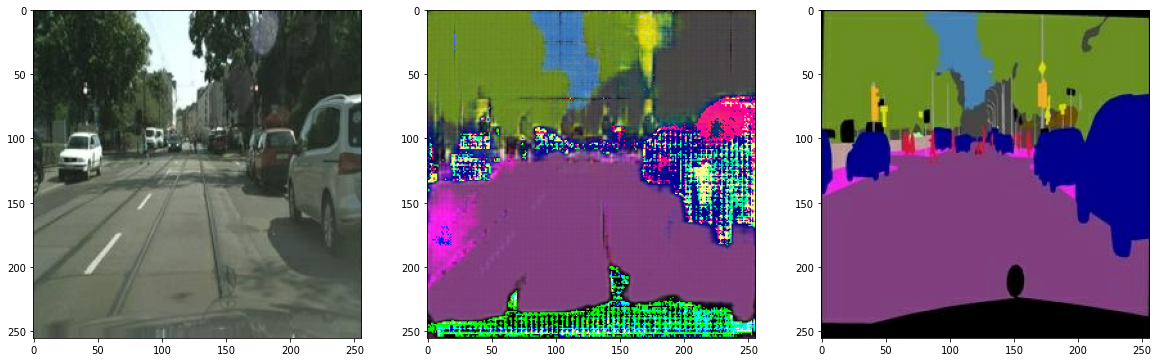

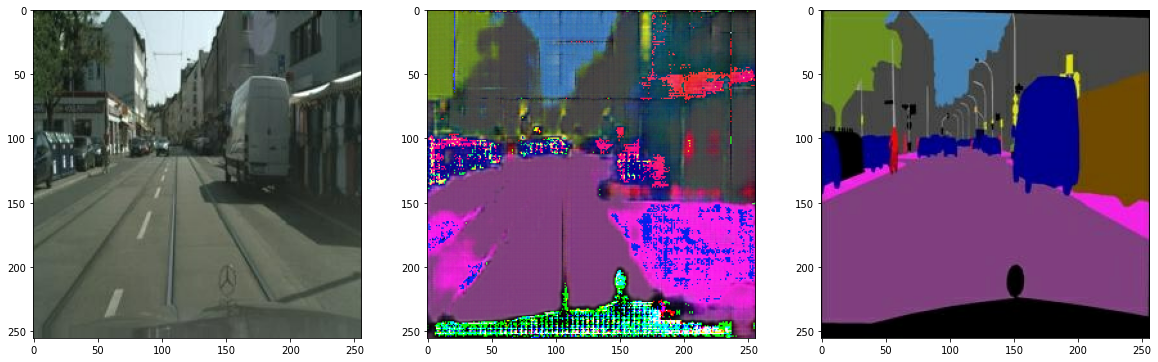

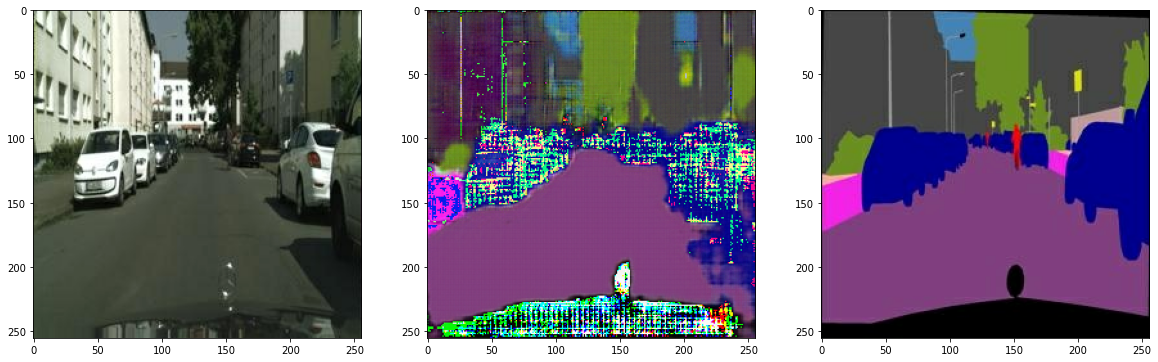

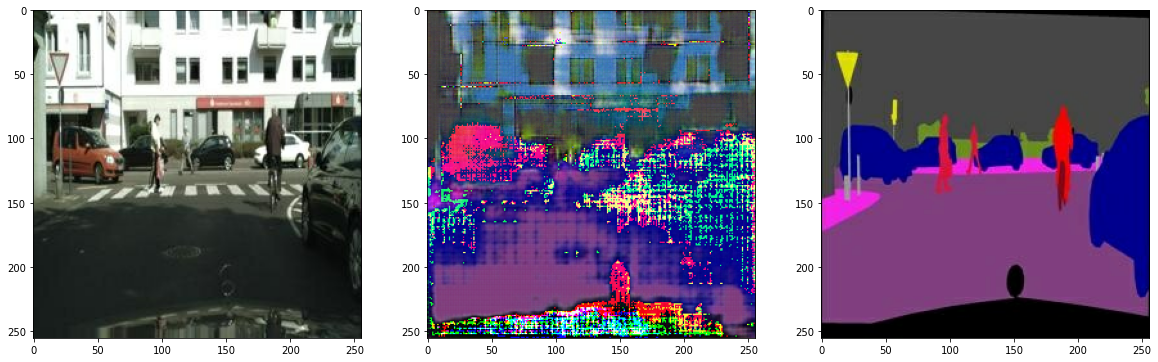

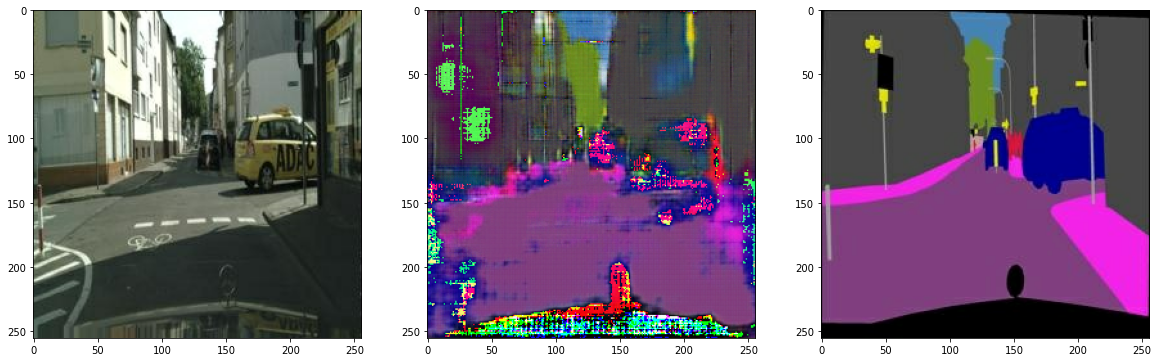

In [59]:
#test_ind = 1

for test_ind in range(5):

    f = data_path_val + os.listdir(data_path_val)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 회고
* Pix2Pix 논문 [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf)의 내용을 구현해보는 프로젝트였음.
* 노드에 이미 논문의 내용을 바탕으로 구현이 되어 있어서, dataset만 바꿔서 진행하였기에 과제 수행에는 어려움이 없었지만, 더 나아가 논문을 보고 구현까지는 아니더라도 이해하도록 연습을 해야겠음


## 참고문헌 
1. [꼼꼼한 딥러닝 논문 리뷰와 코드 실습](https://www.youtube.com/watch?v=ImiD4npRj7k)